In [1]:
# Load Transaction Data from a CSV File

### DISCLAIMER: 
### FOR ALL TAX-RELATED QUESTIONS AND CONCERNS PLEASE ASK A CERTIFIED ACCOUNTANT

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

# TODO: move your MINT.com transactions.csv into this project directory
# / the directory where you are running jupyter notebook
PATH_TO_YOUR_TRANSACTIONS = "transactions.csv"
PATH_TO_UTILITIY_LIMITS = 'util-limits.csv'

# Set the name of the column where the transactions are categorized
# In Mint this is usually "Category".  I use Mint's category to link 
# transactions to a property and the add a seperate "Label" column
# after exporting the data for a property from Min
CATEGORY = "Label"

# Load the transaction data from the csv into a dataframe
parse_dates = ['Date']
df = pd.read_csv(PATH_TO_YOUR_TRANSACTIONS, parse_dates=parse_dates)
df.set_index(['Date'], inplace=True)
df['Amount'] = df['Amount'].astype(float)

# Get rid of Mint columns that we don't care about
df.drop(['Original Description','Actual Amount','Notes'], axis=1, inplace=True)
#df.head()

In [2]:
# Show the Utility Payments and Reimbursements By Year
utils_df = df[df[CATEGORY] == 'Utilities']
g = utils_df.groupby([utils_df.index.year, "Unit", "Transaction Type"])
utils = g.sum()
u = utils.unstack(-1).fillna(0)


                 Amount                                          
Transaction Type credit                   debit                  
Unit                 1E      1W     2F       1E       1W       2F
Date                                                             
2017               95.0    0.00  100.0  1097.37  1167.52  1624.53
2018               73.0  101.28  379.0   942.69  1254.34  1772.18


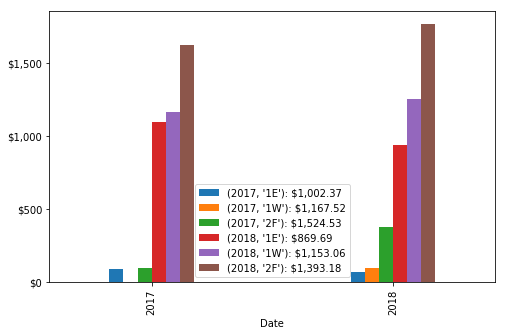

In [3]:
# Visualize the Utilties Costs 
ax = plt.subplot()
u.unstack().plot.bar(figsize=[8,5], width=0.35, ax=ax)
print(u.unstack())

# Show the net cost on the legend
legend_labels = []
for year,row in u.iterrows():
    net = row['Amount','debit'] - row['Amount','credit']
    legend_labels.append(str(year) + ': ${:,.2f}'.format(net))
ax.legend(legend_labels)

# Format the yticks as currency
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
tick_spacing = 500
ax.yaxis.set_major_locator(mtick.MultipleLocator(tick_spacing))

# Semicolot after plot hides a bunch of garbage showing in jupyter
plt.show();

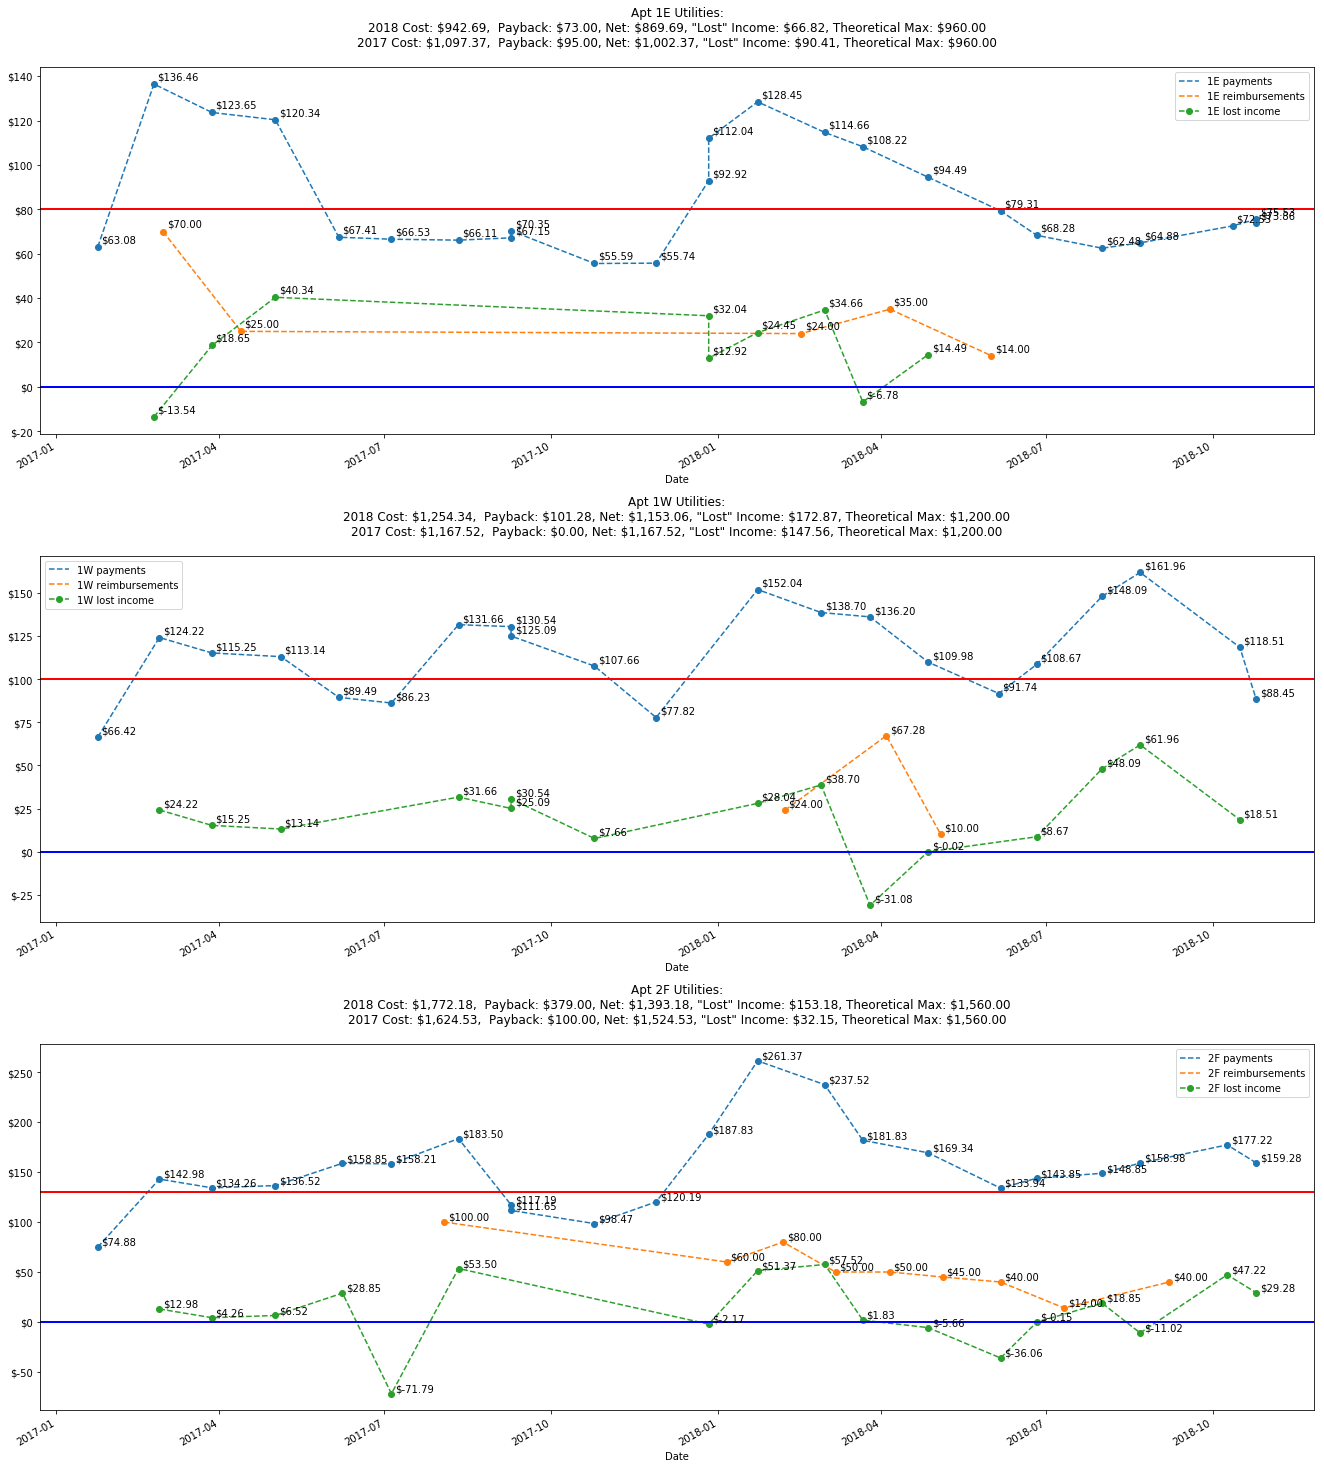

In [4]:
# Visualize Utility Costs by Unit

utils_df = df[(df[CATEGORY] == 'Utilities') & (df['Transaction Type'] == 'debit')]
utils_reimb_df = df[(df[CATEGORY] == 'Utilities') & (df['Transaction Type'] == 'credit')]

# Read in the monthly max before reimbursement.
limit_df = pd.read_csv(PATH_TO_UTILITIY_LIMITS)
limit_df.set_index(['Unit'], inplace=True)
limit_df['Amount'] = limit_df['Amount'].astype(float)
# print(limit_df)

# Grab all utilities paymens and the annual totals
utils_df = df[(df[CATEGORY] == 'Utilities')]
payments = utils_df.groupby(['Unit', utils_df.index.year,'Transaction Type']).sum()
payments = payments.unstack().fillna(0)

# Cycle through each unit
units = utils_df['Unit'].unique()
fig, axs = plt.subplots(3, 1)
plt.subplots_adjust(hspace=1.5)
graph_num = 0

# Calculate the difference between the payment and reimbursement when one was made
def find_lost_income(row, payments):
    mask = (payback.index >= row.name) & (payback.index <= row.name+datetime.timedelta(+30))
    if not payback.loc[mask].empty:
        row['Amount'] -= payback.loc[mask]['Amount'].sum()
    return row['Amount']

import datetime
for unit in units:
    # Grab the details for each unit and plot them
    expense = utils_df[(utils_df['Unit'] == unit) & (utils_df['Transaction Type'] == 'debit')]
    payback = utils_df[(utils_df['Unit'] == unit) & (utils_df['Transaction Type'] == 'credit')]
    lost_income = expense.copy()
    lost_income['Amount'] = expense['Amount'] - limit_df.loc[unit].Amount
    lost_income = lost_income[lost_income['Amount'] > 0]
    lost_income['Amount'] = lost_income.apply(find_lost_income, axis=1, payments=payments)
    
    axs[graph_num] = expense.plot(ax=axs[graph_num], kind='line', x=expense.index, y='Amount', label=unit+' payments', linestyle='--', marker='o')
    for i,j in zip(expense.index, expense['Amount']):
        axs[graph_num].annotate('${:,.2f}'.format(j), xy=(mdates.date2num(i)+2, j+2))

    axs[graph_num] = payback.plot(ax=axs[graph_num], kind='line', x=payback.index, y='Amount', label=unit+' reimbursements', linestyle='--', marker='o')
    for i,j in zip(payback.index, payback['Amount']):
        axs[graph_num].annotate('${:,.2f}'.format(j), xy=(mdates.date2num(i)+2, j+2))
        
    axs[graph_num] = lost_income.plot(ax=axs[graph_num], kind='line', x=lost_income.index, y='Amount', label=unit+' lost income', linestyle='--', marker='o')
    for i,j in zip(lost_income.index, lost_income['Amount']):
        axs[graph_num].annotate('${:,.2f}'.format(j), xy=(mdates.date2num(i)+2, j+2))
    lost_income = lost_income.groupby([lost_income.index.year]).sum()

        
    # Put the annual totals in the title
    title = 'Apt '+ unit + ' Utilities:\n';
    for year in utils_df.index.year.unique():
        title += str(year) + ' Cost: '+ '${:,.2f}'.format(payments.loc[(unit, year)]['Amount'].debit) + \
            ', ' + ' Payback: '+ '${:,.2f}'.format(payments.loc[(unit, year)]['Amount'].credit) + ', ' +\
            'Net: ' + '${:,.2f}'.format(payments.loc[(unit, year)]['Amount'].debit - payments.loc[(unit, year)]['Amount'].credit) +\
            ', \"Lost\" Income: '+ '${:,.2f}'.format(lost_income.loc[(year)].Amount.sum())
            
        # Put the monthly limit
        if unit in limit_df.index.unique():
            axs[graph_num].axhline(y=limit_df.loc[unit].Amount, linewidth=2, color='r', label='Monthly Max')
            title += ', ' + 'Theoretical Max: ' + '${:,.2f}'.format(12 * limit_df.loc[unit].Amount)
            
        title +='\n'
        
    axs[graph_num].axhline(y=0, linewidth=2, color='b')
    axs[graph_num].set_title(title)

    # Format the yticks as currency
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    axs[graph_num].yaxis.set_major_formatter(tick) 

    graph_num += 1
    
fig.set_size_inches(18.5, 20.5)
fig.tight_layout()
# plt.savefig('utilities_by_unit.png')
plt.show();
